In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multivariateGCI_mr import MultivariateGCI_mr
from multivariateGCI_sr import MultivariateGCI_sr

from qiskit import QuantumRegister, QuantumCircuit, Aer, execute
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeGuadalupe
from qiskit.providers.aer import QasmSimulator 
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit import transpile
from qiskit.converters import circuit_to_dag

### ideas: 
- reset the qubits representing the distribution(s)
- use piecewise rotations to read distribution and directly rotate using offset (single rotation)

In [2]:
import pandas as pd
from itertools import combinations

df = pd.read_csv("Data/sampled_counterparts.csv")
# df = df[((df['pd']>=0.1) & ((1000 < df['lgd dwt']*df['ead']) & (df['lgd dwt']*df['ead'] < 5000000)))]
df = df.iloc[[38-2, 260-2]]#, 7816-2]] 

F_matrix = pd.read_csv("Data/F_for_sampled_counterparts.csv")
sectors = [1, 2]
F_values = [[F_matrix.iloc[df.index.values[j]][i-1] for i in sectors] for j in range(len(df))]
# F_values = [[0.55], [0.65], [0.50]] # make F/rhos

In [3]:
# Build noise model from backend properties
fake_backend = FakeGuadalupe()

# set problem parameters
n_z = 2
z_max = 2

p_zeros = [el['pd'] for _, el in df.iterrows()]
rhos = [el['is']**2 for _, el in df.iterrows()]
lgd = [el['lgd dwt']*el['ead'] for _, el in df.iterrows()]

K = len(p_zeros)

n_shots = 2048
optimization_level = 1

print(f'F: {F_values}\nRhos: {np.sqrt(rhos)}\nLgds: {lgd}\np_zeros: {p_zeros}')
df

F: [[0.1580707722, 0.057751624756012], [0.2555327991, 0.157171844120119]]
Rhos: [0.3 0.3]
Lgds: [18406.56224845756, 54807.94141703075]
p_zeros: [0.2565108504, 0.0715568886]


,cluster,pd,lgd dwt,ead,num ctp,sett,is,acca,cod type,cod stato,lgd pag
36,005118_618,0.256511,0.223071,82514.537908,83292,5,0.3,0.000083,0,0,0.187699
258,002116_18,0.071557,0.194311,282063.242107,888,2,0.3,0.019318,0,0,0.157672


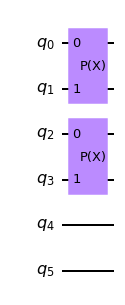

In [4]:
u = MultivariateGCI_mr(n_z, z_max, p_zeros, rhos, F_values)

u.decompose().draw("mpl", filename='Images/u_circuit.svg')

In [5]:
from scipy.stats import norm
n_factors = n_z*len(sectors)

def rotation_mapping(decimal_number, k):
    b = ('{0:0%sb}' % n_factors).format(decimal_number)
    realizations = []
    for i in range(len(sectors)):
        bin = b[n_z*i:n_z*(i+1)]
        realizations.append(int(bin, 2) * 2 * z_max / (2 ** n_z - 1) - z_max)
        # print(realizations[i])
    
    p = norm.cdf(
        (
        norm.ppf(p_zeros[k]) - np.sum([F*realization for F, realization in zip(F_values[k], realizations)])
        ) / np.sqrt(1-rhos[k])
    ) 
    

    return p

In [6]:

# define linear objective function for expected loss
breakpoints = list(range(0,2**(n_z*len(sectors)))) 
slopes = [0]*len(breakpoints)
offsets_list = []
f_min = 0
f_max = 1
c_approx = 0.01
objective_rotation_list = []
for i in range(K):
    offsets_list.append([rotation_mapping(el, i) for el in breakpoints])
    objective_rotation_list.append(LinearAmplitudeFunction(
        n_factors,
        slope=slopes, 
        offset=offsets_list[i], 
        # max value that can be reached by the qubit register (will not always be reached)
        domain=(0, 2**(n_factors)-1),  
        image=(f_min, f_max),
        rescaling_factor=c_approx,
        breakpoints=breakpoints
    ))

In [7]:
def mapping(decimal_number):
    b = ('{0:0%sb}' % K).format(decimal_number)
    # print(b)
    losses = [loss for i, loss in enumerate(lgd[::-1]) if b[i]=='1']
    # print(losses)
    total_loss = sum(losses)
    return total_loss

def find_breakpoint(x_eval):
    for el in range(0,2**K):
        if mapping(el) <= x_eval:
            if mapping(el+1) >= x_eval:
                return el
    return 0

In [8]:
# define linear objective function for expected loss
breakpoints = list(range(0,2**K))
slopes = [0]*len(breakpoints)
offsets = [mapping(el) for el in breakpoints]
f_min = 0
f_max = sum(lgd)
c_approx = 0.01

objective_e_loss = LinearAmplitudeFunction(
    K,
    slope=slopes, 
    offset=offsets, 
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2**K-1),  
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints
)

In [9]:
from qiskit.circuit.library import LinearAmplitudeFunction


def get_cdf_circuit(x_eval):
    
    # define linear objective function for cdf
    breakpoints = list(range(0,2**K))
    slopes = [0]*len(breakpoints)
    # print(values)
    offsets = [1 if mapping(el)<=x_eval else 0 for el in breakpoints]
    f_min = 0
    f_max = 1
    c_approx = 0.01
    
    objective = LinearAmplitudeFunction(
        K,
        slope=slopes, 
        offset=offsets, 
        # max value that can be reached by the qubit register (will not always be reached)
        domain=(0, 2**K-1),  
        image=(f_min, f_max),
        rescaling_factor=c_approx,
        breakpoints=breakpoints
    )

    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, 'state')
    qr_obj = QuantumRegister(1, 'objective')
    ar = QuantumRegister(objective.num_ancillas, "work")  # additional qubits
    ar_rotation = QuantumRegister(objective_rotation_list[0].num_ancillas, "work_rotation")  # additional qubits

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, ar, ar_rotation, name='A')

    # load the random variable
    state_preparation.append(u.to_gate(), qr_state)

    for i in range(K):
        state_preparation.append(objective_rotation_list[i].to_gate(), qr_state[:n_factors] + qr_state[n_factors+i:n_factors+i+1] + ar_rotation[:])

    # linear objective function (does aggregation and comparison)
    state_preparation.append(objective_e_loss.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
    return state_preparation, objective_e_loss
    
example = 0
state_preparation, objective = get_cdf_circuit(example)
job = execute(state_preparation, backend=Aer.get_backend('statevector_simulator'))

# evaluate resulting statevector
var_prob = 0
for i, a in enumerate(np.array(job.result().get_statevector())):
    b = ('{0:0%sb}' % (u.num_qubits + 1)).format(i)[-(u.num_qubits + 1):]
    prob = np.abs(a)**2
    if b[0] == '1':
        var_prob += prob

print('Operator Expected Loss' + ' = %.4f' % objective.post_processing(var_prob))

state_preparation.draw()
# objective.decompose().decompose().draw()

Operator Expected Loss = 36165.7173


┌───────┐┌────┐┌────┐      
        state_0: ┤0      ├┤0   ├┤0   ├──────
                 │       ││    ││    │      
        state_1: ┤1      ├┤1   ├┤1   ├──────
                 │       ││    ││    │      
        state_2: ┤2      ├┤2   ├┤2   ├──────
                 │  P(X) ││    ││    │      
        state_3: ┤3      ├┤3   ├┤3   ├──────
                 │       ││    ││    │┌────┐
        state_4: ┤4      ├┤4   ├┤    ├┤0   ├
                 │       ││    ││    ││    │
        state_5: ┤5      ├┤    ├┤4   ├┤1   ├
                 └───────┘│    ││    ││    │
      objective: ─────────┤  F ├┤  F ├┤2 F ├
                          │    ││    ││    │
         work_0: ─────────┤    ├┤    ├┤3   ├
                          │    ││    ││    │
         work_1: ─────────┤    ├┤    ├┤4   ├
                          │    ││    │└────┘
work_rotation_0: ─────────┤5   ├┤5   ├──────
                          │    ││    │      
work_rotation_1: ─────────┤6   ├┤6   ├──────
                          │    ││    │      
work_rotation_2: ─────────┤7   ├┤7   ├──────
                          │    ││    │      
work_rotation_3: ─────────┤8   ├┤8   ├──────
                          └────┘└────┘

In [10]:
import time
# set target precision and confidence level
epsilon = 0.03
alpha = 0.1

device = QasmSimulator.from_backend(fake_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

qi_ideal = QuantumInstance(Aer.get_backend('aer_simulator'), shots=n_shots, 
                           optimization_level=optimization_level, seed_transpiler=42)

# qi_noise = QuantumInstance(provider.get_backend('ibm_perth'), shots=n_shots, 
#                             optimization_level=optimization_level, seed_transpiler=42)

qi_noise = QuantumInstance(QasmSimulator.from_backend(fake_backend), shots=n_shots, 
                           optimization_level=optimization_level, seed_transpiler=42)

In [11]:
start_time = time.time()
problem = EstimationProblem(state_preparation=state_preparation,
                            objective_qubits=[u.num_qubits],
                            post_processing=objective.post_processing)
# construct amplitude estimation 
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi_ideal)
result = ae.estimate(problem)
q_samples_ideal = 2**len(result.powers)-1
# save results
conf_int_ideal = np.array(result.confidence_interval_processed)
result_ideal = result.estimation_processed
runtime_ideal = time.time() - start_time
ideal_result = result

print("result with no noise:", result_ideal)

result with no noise: 4807.135818755142


In [12]:

ae_circuit = ae.construct_circuit(problem, k=31)
tr_ae_circuit = transpile(ae_circuit, optimization_level=optimization_level, backend=fake_backend, seed_transpiler=42)
print(tr_ae_circuit.depth()) # Return circuit depth (i.e., length of critical path).
print(tr_ae_circuit.size()) # Returns total number of instructions in circuit.

ae_circuit.decompose().draw("mpl", style="iqx")
#plot_circuit_layout(tr_ae_circuit, fake_backend)
# ae_circuit.decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().size()


dag_circuit = circuit_to_dag(tr_ae_circuit)
print("longest_path: ",dag_circuit.count_ops_longest_path())

1821357
2552744
longest_path:  {'cx': 1383213, 'rz': 414187, 'sx': 19753, 'x': 4204}
